<a href="https://colab.research.google.com/github/danielapavas/Porto_seguro_safe_driver_prediction/blob/main/fase-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Carga de dataset desde Kaggle**

El dataset es tomado de la competencia de Kaggle: https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/overview

In [ ]:
!pip install kaggle

In [ ]:
#carga del token de kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielapavas","key":"c2bccd2eb61b7f7167c20b7ee01878ab"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c porto-seguro-safe-driver-prediction

 95% 73.0M/76.5M [00:03<00:00, 33.5MB/s]
100% 76.5M/76.5M [00:03<00:00, 25.4MB/s]


In [ ]:
!unzip porto-seguro-safe-driver-prediction.zip

Archive:  porto-seguro-safe-driver-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# **IMPORTS**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import  roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

import random

%matplotlib inline

import xgboost as xgb

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier

# **Dataset y simulacion de datos faltantes(NAN)**

In [ ]:
# Cargar los conjuntos de datos
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

test_id = test['id']
test.drop('id', axis=1, inplace=True)
y = train['target']
train =train.drop(['id','target'], axis=1)

In [ ]:
train.shape, test.shape

((595212, 59), (892816, 58))

In [ ]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [ ]:
test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


In [ ]:
# datos faltantes a simular (5%)
frac_missing = 0.05

# 3 columnas para simular datos faltantes
columns_with_missing = ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin']

for column in columns_with_missing:
    # cantidad de filas para simular datos faltantes
    num_missing_test = int(test.shape[0] * frac_missing)

    # índices aleatorios para las filas a las que se les asignarán valores faltantes
    missing_indices_test = np.random.choice(test.shape[0], num_missing_test, replace=False)

    # Asigna NaN a las filas seleccionadas en la columna actual en ambos conjuntos
    train.loc[:, column] = np.nan
    test.loc[:, column] = np.nan


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   0 non-null       float64
 8   ps_ind_07_bin   0 non-null       float64
 9   ps_ind_08_bin   0 non-null       float64
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              892816 non-null  int64  
 1   ps_ind_01       892816 non-null  int64  
 2   ps_ind_02_cat   892816 non-null  int64  
 3   ps_ind_03       892816 non-null  int64  
 4   ps_ind_04_cat   892816 non-null  int64  
 5   ps_ind_05_cat   892816 non-null  int64  
 6   ps_ind_06_bin   0 non-null       float64
 7   ps_ind_07_bin   0 non-null       float64
 8   ps_ind_08_bin   0 non-null       float64
 9   ps_ind_09_bin   892816 non-null  int64  
 10  ps_ind_10_bin   892816 non-null  int64  
 11  ps_ind_11_bin   892816 non-null  int64  
 12  ps_ind_12_bin   892816 non-null  int64  
 13  ps_ind_13_bin   892816 non-null  int64  
 14  ps_ind_14       892816 non-null  int64  
 15  ps_ind_15       892816 non-null  int64  
 16  ps_ind_16_bin   892816 non-null  int64  
 17  ps_ind_17_

# **Métrica de puntuación de kaggle**

Se evalua la métrica sugerida en Kaggle:
Código para calcular el coeficiente de Gini normalizado de: https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703


In [ ]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2
    return giniSum / len(actual)

def gini_normalized(a, p):
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

In [ ]:
#valores faltantes
def missing_values(data):
    '''Function to find the percentage of missing values in each column of a DataFrame passed'''
    for i in data.columns.values:
        count =  data[data[i] == -1].shape[0]
        print("Missing Values in '{}' : {:.4f} %".format(i, (count/data.shape[0])*100))

In [ ]:
#Relleno de valores faltantes
def filling_missing_values(data):
    '''A function to fill in the missing values of categorical features'''
    for i in tqdm(data.columns.values):
        if data[data[i] == -1].shape[0] > 0:
            if i == 'ps_car_03_cat' or i == 'ps_car_05_cat':
                continue
            elif i == 'ps_ind_05_cat' or i == 'ps_car_07_cat':
                lst = data[i].apply(lambda x:data[i].mode() if x == -1 else x)
                data[i] = pd.Series(lst)
            else:
                lst = data[i].apply(lambda x:data[i].mean() if x == -1 else x)
                data[i] = pd.Series(lst)
        else:
            continue
    return data

In [ ]:
def one_hot_encoding(train, test, cat_features):
    '''Function to one-hot-encode categorical features'''
    temp = pd.concat([train, test])
    temp = pd.get_dummies(temp, columns = cat_features)
    train = temp.iloc[:train.shape[0],:]
    test = temp.iloc[train.shape[0]:, :]
    return train, test

In [ ]:
def target_encoding(train, test, target, cat_features):
    '''Function to target encode categorical data'''
    prior = target.mean()
   # features = train.columns.values
    train['target'] = target

    def smooth(x, mean, count, prior, smoothing=1, min_samples_leaf = 1):
        smoothing = 1 / (1 + np.exp(-(count - min_samples_leaf) / smoothing))
        return (prior * (1 - smoothing) + mean * smoothing)

    for i in cat_features:

        v = train.groupby(i)['target'].agg(['mean','count'])

        train[i] = train[i].apply(lambda x : smooth(x, v['mean'][x], v['count'][x], prior))
        test[i] = test[i].apply(lambda x : smooth(x, v['mean'][x], v['count'][x], prior))

    train.drop(['target'], axis=1, inplace = True)

    return train, test

In [ ]:
def label_encoding(train, test, cat_features):
    '''Function to label encode categorical variables'''
    for i in cat_features:
        le = LabelEncoder()
        le.fit(train[i])
        train[i] = le.transform(train[i])
        test[i] = le.transform(test[i])
    return train, test

In [ ]:
def freq_encoding(train, test, cat_features):
    '''Function to frequency encode categorical variables'''
    for i in cat_features:
        vc = train[i].value_counts()
        train[i] = train[i].apply(lambda x: vc[x])
        test[i] = test[i].apply(lambda x: vc[x])
    return train, test

# **Exploración de los datos**

In [ ]:
imbalance = y.value_counts()
print("Porcentaje de seguro reclamado(Clase 1) : ", (imbalance[1]/train.shape[0])*100)
print("PPorcentaje de seguro  NO reclamado(Clase 0) : ", (imbalance[0]/train.shape[0])*100)

Porcentaje de seguro reclamado(Clase 1) :  3.6447517859182947
PPorcentaje de seguro  NO reclamado(Clase 0) :  96.3552482140817


El conjunto de datos esta muy desequilibrado: (96:4)

In [ ]:
#categoriza las caracteristicas del conjunto de datos
all_features = train.columns.values
cat_features = []
for i in train.columns.values:
    if i.endswith('cat'):
        cat_features.append(i)
    else:
        continue

bin_features = []
for i in train.columns.values:
    if i.endswith('bin'):
        bin_features.append(i)
    else:
        continue

calc_features = []
for i in train.columns.values:
    if i.startswith('ps_calc'):
        calc_features.append(i)
    else:
        continue

calc_bin_features = []
for i in calc_features:
    if i.endswith('bin'):
        calc_bin_features.append(i)
    else:
        continue

calc_num_features = list(set(calc_features) - set(calc_bin_features))
num_features_with_calc = list((set(train.columns.values) - set(cat_features)) - set(bin_features))
num_features_wo_calc = list(set(num_features_with_calc) - set(calc_features))

## **Características binarias**

<Axes: title={'center': 'Correlation Between Binary Features'}>

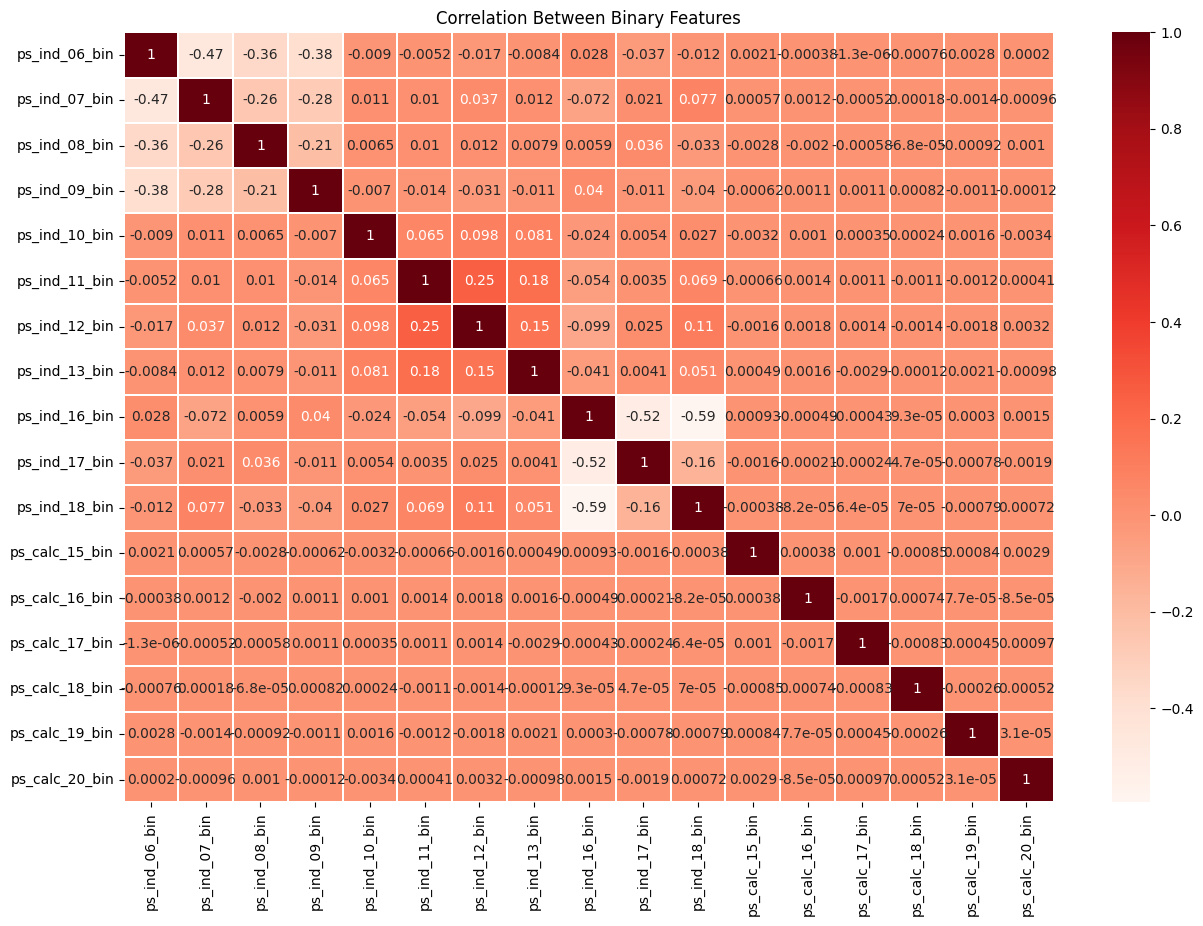

In [ ]:
plt.figure(figsize=(15,10))
plt.title("Correlation Between Binary Features")
sns.heatmap(train[bin_features].corr(), cmap='Reds', annot = True, linewidths=0.01)

Las características binarias no tienen ninguna correlación notable entre ellas. 'ps_ind_18_bin' y 'ps_ind_16_bin' tienen la correlación negativa más grande.

In [ ]:
missing_values(train[bin_features])

Missing Values in 'ps_ind_06_bin' : 0.0000 %
Missing Values in 'ps_ind_07_bin' : 0.0000 %
Missing Values in 'ps_ind_08_bin' : 0.0000 %
Missing Values in 'ps_ind_09_bin' : 0.0000 %
Missing Values in 'ps_ind_10_bin' : 0.0000 %
Missing Values in 'ps_ind_11_bin' : 0.0000 %
Missing Values in 'ps_ind_12_bin' : 0.0000 %
Missing Values in 'ps_ind_13_bin' : 0.0000 %
Missing Values in 'ps_ind_16_bin' : 0.0000 %
Missing Values in 'ps_ind_17_bin' : 0.0000 %
Missing Values in 'ps_ind_18_bin' : 0.0000 %
Missing Values in 'ps_calc_15_bin' : 0.0000 %
Missing Values in 'ps_calc_16_bin' : 0.0000 %
Missing Values in 'ps_calc_17_bin' : 0.0000 %
Missing Values in 'ps_calc_18_bin' : 0.0000 %
Missing Values in 'ps_calc_19_bin' : 0.0000 %
Missing Values in 'ps_calc_20_bin' : 0.0000 %


Las características binarias no contienen valores faltantes.

## **Características categoricas**

In [ ]:
for i in cat_features:
    cardinality = len(list(train[i].unique()))
    print("Cardinality of '{}' : {}".format(i, cardinality))

Cardinality of 'ps_ind_02_cat' : 5
Cardinality of 'ps_ind_04_cat' : 3
Cardinality of 'ps_ind_05_cat' : 8
Cardinality of 'ps_car_01_cat' : 13
Cardinality of 'ps_car_02_cat' : 3
Cardinality of 'ps_car_03_cat' : 3
Cardinality of 'ps_car_04_cat' : 10
Cardinality of 'ps_car_05_cat' : 3
Cardinality of 'ps_car_06_cat' : 18
Cardinality of 'ps_car_07_cat' : 3
Cardinality of 'ps_car_08_cat' : 2
Cardinality of 'ps_car_09_cat' : 6
Cardinality of 'ps_car_10_cat' : 3
Cardinality of 'ps_car_11_cat' : 104


La característica 'ps_car_11_cat' se destaca entre las características categóricas ya que tiene la cardinalidad más alta. Resto todas las características tienen una cardinalidad relativamente baja.

In [ ]:
missing_values(train[cat_features])

Missing Values in 'ps_ind_02_cat' : 0.0363 %
Missing Values in 'ps_ind_04_cat' : 0.0139 %
Missing Values in 'ps_ind_05_cat' : 0.9760 %
Missing Values in 'ps_car_01_cat' : 0.0180 %
Missing Values in 'ps_car_02_cat' : 0.0008 %
Missing Values in 'ps_car_03_cat' : 69.0898 %
Missing Values in 'ps_car_04_cat' : 0.0000 %
Missing Values in 'ps_car_05_cat' : 44.7825 %
Missing Values in 'ps_car_06_cat' : 0.0000 %
Missing Values in 'ps_car_07_cat' : 1.9302 %
Missing Values in 'ps_car_08_cat' : 0.0000 %
Missing Values in 'ps_car_09_cat' : 0.0956 %
Missing Values in 'ps_car_10_cat' : 0.0000 %
Missing Values in 'ps_car_11_cat' : 0.0000 %


cat_features contiene algunos valores faltantes.
Una gran parte de las características 'ps_car_03_cat' y 'ps_car_05_cat' se componen de valores faltantes.

<Axes: title={'center': 'Correlation Between Categorical Features'}>

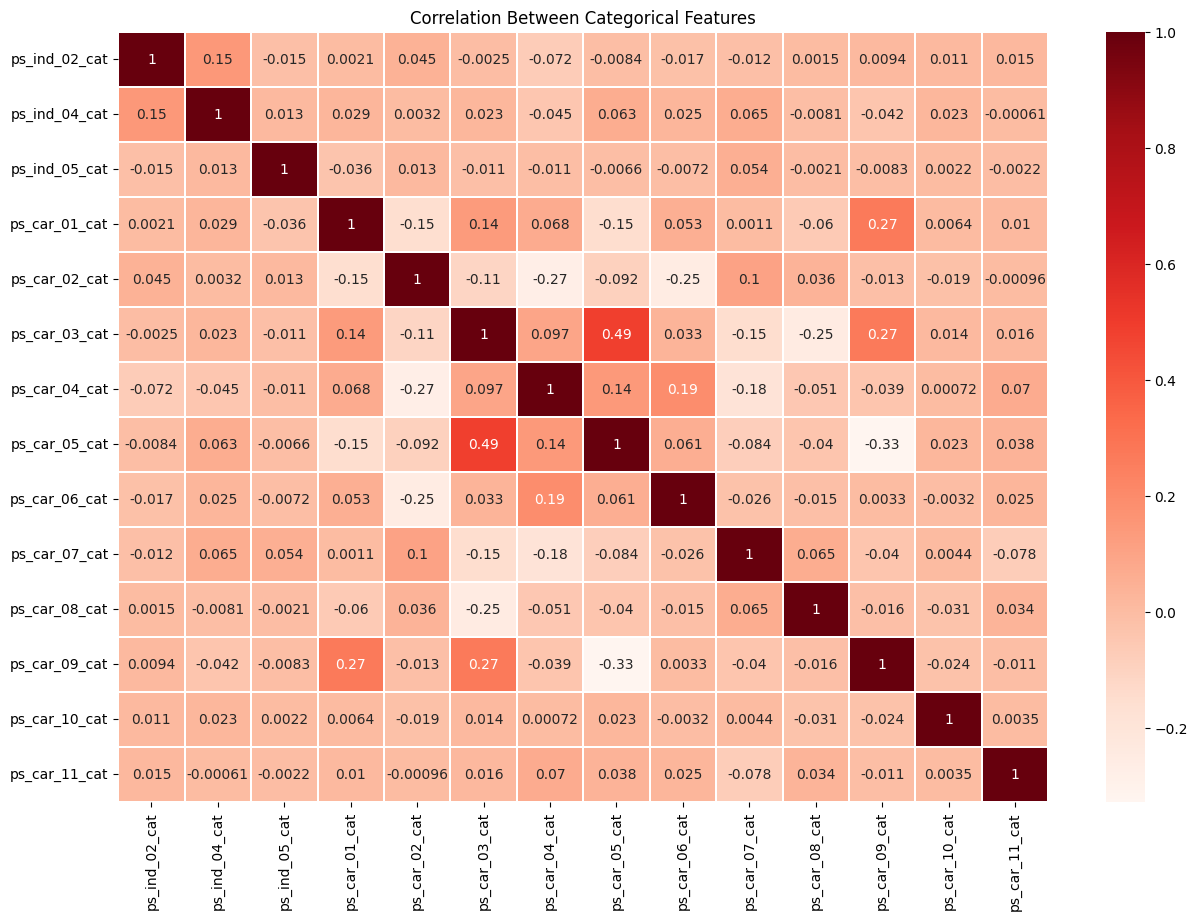

In [ ]:
plt.figure(figsize=(15,10))
plt.title("Correlation Between Categorical Features")
sns.heatmap(train[cat_features].corr(), cmap='Reds', annot = True, linewidths=0.01)

Las características categóricas no tienen ninguna correlación notable entre ellas.

## **Características continuas**

Las funciones continuas se pueden separar en calc y el resto. Ambos se pueden buscar por separado.

In [ ]:
train[num_features_with_calc].describe()

,ps_ind_15,ps_calc_03,ps_calc_11,ps_calc_04,ps_ind_01,ps_car_12,ps_calc_01,ps_calc_08,ps_car_13,ps_calc_13,...,ps_ind_14,ps_calc_06,ps_reg_03,ps_calc_12,ps_calc_05,ps_reg_02,ps_calc_09,ps_reg_01,ps_car_14,ps_calc_10
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.299922,0.449849,5.441382,2.372081,1.900378,0.379945,0.449756,9.225904,0.813265,2.872288,...,0.012451,7.689445,0.551102,1.441918,1.885886,0.439184,2.339034,0.610991,0.276256,8.433590
std,3.546042,0.287153,2.332871,1.117219,1.983789,0.058327,0.287198,1.459672,0.224588,1.694887,...,0.127545,1.334312,0.793506,1.202963,1.134927,0.404264,1.246949,0.287643,0.357154,2.904597
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,2.000000,0.250619,0.000000,...,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,5.000000,0.200000,4.000000,2.000000,0.000000,0.316228,0.200000,8.000000,0.670867,2.000000,...,0.000000,7.000000,0.525000,1.000000,1.000000,0.200000,1.000000,0.400000,0.333167,6.000000
50%,7.000000,0.500000,5.000000,2.000000,1.000000,0.374166,0.500000,9.000000,0.765811,3.000000,...,0.000000,8.000000,0.720677,1.000000,2.000000,0.300000,2.000000,0.700000,0.368782,8.000000
75%,10.000000,0.700000,7.000000,3.000000,3.000000,0.400000,0.700000,10.000000,0.906190,4.000000,...,0.000000,9.000000,1.000000,2.000000,3.000000,0.600000,3.000000,0.900000,0.396485,10.000000
max,13.000000,0.900000,19.000000,5.000000,7.000000,1.264911,0.900000,12.000000,3.720626,13.000000,...,4.000000,10.000000,4.037945,10.000000,6.000000,1.800000,7.000000,0.900000,0.636396,25.000000


In [ ]:
missing_values(train[num_features_wo_calc])

Missing Values in 'ps_ind_15' : 0.0000 %
Missing Values in 'ps_reg_02' : 0.0000 %
Missing Values in 'ps_reg_03' : 18.1065 %
Missing Values in 'ps_car_11' : 0.0008 %
Missing Values in 'ps_ind_03' : 0.0000 %
Missing Values in 'ps_reg_01' : 0.0000 %
Missing Values in 'ps_car_14' : 7.1605 %
Missing Values in 'ps_car_13' : 0.0000 %
Missing Values in 'ps_car_15' : 0.0000 %
Missing Values in 'ps_ind_01' : 0.0000 %
Missing Values in 'ps_ind_14' : 0.0000 %
Missing Values in 'ps_car_12' : 0.0002 %


In [ ]:
missing_values(train[calc_num_features])

Missing Values in 'ps_calc_07' : 0.0000 %
Missing Values in 'ps_calc_03' : 0.0000 %
Missing Values in 'ps_calc_14' : 0.0000 %
Missing Values in 'ps_calc_09' : 0.0000 %
Missing Values in 'ps_calc_11' : 0.0000 %
Missing Values in 'ps_calc_10' : 0.0000 %
Missing Values in 'ps_calc_01' : 0.0000 %
Missing Values in 'ps_calc_04' : 0.0000 %
Missing Values in 'ps_calc_02' : 0.0000 %
Missing Values in 'ps_calc_08' : 0.0000 %
Missing Values in 'ps_calc_13' : 0.0000 %
Missing Values in 'ps_calc_06' : 0.0000 %
Missing Values in 'ps_calc_12' : 0.0000 %
Missing Values in 'ps_calc_05' : 0.0000 %


# **Modelo predictivo**

In [ ]:
#randomforest
#XGBoost

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(train, y, test_size = 0.2, stratify = y, random_state = 2019)

Dado que nuestros datos están muy desequilibrados, realizaremos una división estratificada en nuestro conjunto de datos. Conservará el porcentaje de muestras para nuestra división. Las predicciones de una división no estratificada no preservarán la distribución original de nuestra clase objetivo. Por lo tanto, un conjunto de datos desequilibrado debe dividirse de forma estratificada.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train[num_features_wo_calc])

X_train[num_features_wo_calc] = scaler.transform(X_train[num_features_wo_calc])
X_cv[num_features_wo_calc] = scaler.transform(X_cv[num_features_wo_calc])

In [ ]:
print("X_train Shape : ", X_train.shape)
print("X_cv Shape : ", X_cv.shape)

X_train Shape :  (476169, 57)
X_cv Shape :  (119043, 57)


## **Regresión logística**

In [ ]:
alpha = [0.0001,0.001,0.01,0.03]
auc_lr1 = {}
gini_lr1 = {}
for i in alpha:
    lr = SGDClassifier(loss='log', alpha=i, n_jobs=-1)
    lr.fit(X_train, y_train)

    auc_lr1[i] = roc_auc_score(y_cv, lr.predict_proba(X_cv)[:,1])
    gini_lr1[i] = gini_normalized(y_cv, lr.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_lr1, key=auc_lr1.get)
print('Best Gini:', gini_lr1[h])
print('Best AUC:', auc_lr1[h])
print('Best Parameters:', h)

Best Gini: 0.20842862622226493
Best AUC: 0.6042143131111324
Best Parameters: 0.03


In [ ]:
auc_lr2 = {}
gini_lr2 = {}
alpha = [0.0001,0.001,0.01,0.03]
for i in alpha:
    lr = SGDClassifier(loss='log', alpha=i, penalty = 'l1', n_jobs=-1)
    lr.fit(X_train, y_train)

    auc_lr2[i] = roc_auc_score(y_cv, lr.predict_proba(X_cv)[:,1])
    gini_lr2[i] = gini_normalized(y_cv, lr.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_lr2, key=auc_lr2.get)
print('Best Gini:', gini_lr2[h])
print('Best AUC:', auc_lr2[h])
print('Best Parameters:', h)

Best Gini: 0.2492481263677499
Best AUC: 0.624624063183875
Best Parameters: 0.0001


La regresión logística no parece producir un buen resultado para este problema

## **SVM**

In [ ]:
alpha = [0.0001,0.001,0.01,0.03]
auc_svm1 = {}
gini_svm1 = {}
for i in alpha:
    svm = SGDClassifier(alpha=i, n_jobs=-1)
    calib = CalibratedClassifierCV(svm, cv=3)
    calib.fit(X_train, y_train)

    auc_svm1[i] = roc_auc_score(y_cv, calib.predict_proba(X_cv)[:,1])
    gini_svm1[i] = gini_normalized(y_cv, calib.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_svm1, key=auc_svm1.get)
print('Best Gini:', gini_svm1[h])
print('Best AUC:', auc_svm1[h])
print('Best Parameters:', h)

Best Gini: 0.1308366368719433
Best AUC: 0.5654183184359718
Best Parameters: 0.001


SVM tampoco esta produciendo un buen resultado

## **RandomForest**

In [ ]:
n_est = [1000,1200,1300,1400]
min_samples_leaf = [1000,1100,1200,1300]
auc_rf1 = {}
gini_rf1 = {}
for i in n_est:
    for j in min_samples_leaf:
        rf = RandomForestClassifier(n_estimators=i, min_samples_leaf=j, n_jobs=-1)
        rf.fit(X_train, y_train)

        auc_rf1[(i,j)] = roc_auc_score(y_cv, rf.predict_proba(X_cv)[:,1])
        gini_rf1[(i,j)] = gini_normalized(y_cv, rf.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_rf1, key=auc_rf1.get)
print('Best Gini:', gini_rf1[h])
print('Best AUC:', auc_rf1[h])
print('Best Parameters:', h)

In [ ]:
max_leaf_nodes = [90,100,120,150]
auc_rf2 = {}
gini_rf2 = {}
for i in max_leaf_nodes:
    rf = RandomForestClassifier(n_estimators=1200, min_samples_leaf=1000, max_leaf_nodes=i, n_jobs=-1)
    rf.fit(X_train, y_train)

    auc_rf2[(i,j)] = roc_auc_score(y_cv, rf.predict_proba(X_cv)[:,1])
    gini_rf2[(i,j)] = gini_normalized(y_cv, rf.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_rf2, key=auc_rf2.get)
print('Best Gini:', gini_rf2[h])
print('Best AUC:', auc_rf2[h])
print('Best Parameters:', h)

El RandomForests no esta dando buenos resultados

## **XGBoost**

In [ ]:
n_estimators1 = [700,900,1200,1300]
learning_rate = [0.01,0.1,0.3]
auc_xgb1 = {}
gini_xgb1 = {}
for i in n_estimators1:
    for j in learning_rate:
        xgb_model = xgb.XGBClassifier(n_estimators = i, learning_rate=j, n_jobs=-1, tree_method = 'gpu_hist')
        xgb_model.fit(X_train, y_train)

        auc_xgb1[(i,j)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
        gini_xgb1[(i,j)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_xgb1, key=auc_xgb1.get)
print('Best Gini:', gini_xgb1[h])
print('Best AUC:', auc_xgb1[h])
print('Best Parameters:',h)

In [ ]:
max_depth = [3,5,7,9]
subsample = [0.70,0.8,0.9]
auc_xgb2 = {}
gini_xgb2 = {}
for i in max_depth:
    for j in subsample:
        xgb_model = xgb.XGBClassifier(n_estimators = 1300, learning_rate=0.01, subsample= j, max_depth=i, n_jobs=-1,
                                     tree_method = 'gpu_hist')
        xgb_model.fit(X_train, y_train)

        auc_xgb2[(1300,0.01,i,j)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
        gini_xgb2[(1300,0.01,i,j)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_xgb2, key=auc_xgb2.get)
print('Best Gini:', gini_xgb2[h])
print('Best AUC:', auc_xgb2[h])
print('Best Parameters:', h)

In [ ]:
auc_xgb3 = {}
gini_xgb3 = {}
n_estimators2 = [1250,1300,1350,1400,1450,1500]
for j in n_estimators2:
    xgb_model = xgb.XGBClassifier(n_estimators = j, learning_rate=0.01, subsample= 0.8, max_depth=5, n_jobs=-1,
                                 tree_method = 'gpu_hist')
    xgb_model.fit(X_train, y_train)

    auc_xgb3[(j,0.01,5,0.8)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
    gini_xgb3[(j,0.01,5,0.8)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_xgb3, key=auc_xgb3.get)
print('Best Gini:', gini_xgb3[h])
print('Best AUC:', auc_xgb3[h])
print('Best Parameters:', h)

In [ ]:
auc_xgb4 = {}
gini_xgb4 = {}
lambda_l1 = [0.8,0.9,1]
for j in lambda_l1:
    xgb_model = xgb.XGBClassifier(n_estimators = 1400, learning_rate=0.01, subsample= 0.8, max_depth=5, n_jobs=-1, reg_alpha=j,
                                 tree_method = 'gpu_hist')
    xgb_model.fit(X_train, y_train)

    auc_xgb4[(1400,0.01,5,0.8,j)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
    gini_xgb4[(1400,0.01,5,0.8,j)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_xgb4, key=auc_xgb4.get)
print('Best Gini:', gini_xgb4[h])
print('Best AUC:', auc_xgb4[h])
print('Best Parameters:', h)

In [ ]:
auc_xgb5 = {}
gini_xgb5 = {}
min_child_weight = [98,99,100,101]
for j in min_child_weight:
    xgb_model = xgb.XGBClassifier(n_estimators = 1400, learning_rate=0.01, subsample= 0.8, max_depth=5, n_jobs=-1, reg_alpha=1,
                                 tree_method = 'gpu_hist', min_child_weight=j)
    xgb_model.fit(X_train, y_train)

    auc_xgb5[(1400,0.01,5,0.8,1,j)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
    gini_xgb5[(1400,0.01,5,0.8,1,j)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_xgb5, key=auc_xgb5.get)
print('Best Gini:', gini_xgb5[h])
print('Best AUC:', auc_xgb5[h])
print('Best Parameters:', h)

In [ ]:
#Parámetros finales del modelo.
xgb_params = {}
xgb_params['n_estimators'] = 1600
xgb_params['learning_rate'] = 0.01
xgb_params['max_depth'] = 5
xgb_params['feature_fraction'] = 1
xgb_params['min_child_weight'] = 100
xgb_params['reg_alpha'] = 1
xgb_params['subsample'] = 0.8
xgb_params['tree_method'] = 'gpu_hist'

In [ ]:
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict_proba(X_cv)[:,1]

In [ ]:
roc_auc_score(y_cv, xgb_pred), gini_normalized(y_cv, xgb_pred)

In [ ]:
xgb_model.fit(train_ohe,y)
xgb_test_pred = xgb_model.predict_proba(test_ohe)[:,1]


XGBoost sin selección de funciones:

*   puntuación_pública = 0,28404
*   puntuación_privada = 0,28954

XGBoost con selección de funciones:

*   puntuación_pública = 0,28275
*   puntuación_privada = 0,28976

Xgboost no se usó mucho en la competencia, pero con el ajuste adecuado de los parámetros, los resultados fueron buenos y luego demostró ser una valiosa adición.